# Read and process groundwater data ILVO Field

Load essential Python modules

In [1]:
import pandas as pd
import xlrd
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
#from pandasql import sqldf
import datetime
import csv
import pdb
from tqdm.notebook import tqdm
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter
def minor_formatter(x, ind):
    # only format if we don't overlap with a major tick
    if np.mod(x, 1) < .1:
        return ''
    return '{:.1f}'.format(np.mod(x, 1))
def alternate_formatter(x, ind):
    rm = np.mod(x, 1)
    if np.abs(rm) < .1:
        return '{:d}'.format(int(x))
    return '{:.1f}'.format(rm)
# %matplotlib ipympl

#!pip install traces

### Read Climate Data  (www.dacom.nl)
 username and pass requested from Tom deSwaf


In [4]:
### *** READ Carefully *** ####

# climate data before 22/3/2022 had different format in dacom so we needed 
# to change the format and save it as dacom_weather_data_corrected_march-22.csv
# for this conversion you can use this code:

# df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y').dt.strftime('%d/%m/%Y')
# df['time'] = pd.to_datetime(clim['time']).dt.strftime('%H:%M')
# df.to_csv(os.path.join(path1, 'data', 'raw_data','dacom_weather_data_corrected_march-22.csv'),sep=';', index=False)

# and then append the new weather data manually (not that the data before june 23 is not available in dacom ???)
### -------------------------------------- ####
path1 = os.getcwd()
path = os.path.join(path1, 'data', 'raw_data')
file = os.path.join(path, 'dacom_data.csv')
clim=pd.read_csv(file,sep=';')
clim['date'] = pd.to_datetime(clim['date'], format = '%d/%m/%Y')
clim = clim.dropna(subset=['date'])
clim
# convert climate data to daily
num_cols = clim.columns.drop(['date', 'time'])
clim[num_cols] = clim[num_cols].apply(lambda x: pd.to_numeric(x.str.replace(',', '.'), errors='coerce'))
clim['date'] = pd.to_datetime(clim['date'])
climday = clim.groupby('date').agg({**{col: 'mean' for col in num_cols}, 'precipitation': 'sum'}).reset_index()


### Read data

In [3]:
datapath =  os.path.join(path1, 'data')
baro_ind='AP825'
xls_files = glob.glob(datapath + "\*.xlsx") 
#barometer felt down in pipe on   '2022-05-25 07:25:00'  
#loop over the list of xls files
ind = 0
diver_names={}
alldf={}
for i,f in tqdm(enumerate(xls_files),total=len(xls_files)):
    # read the csv file
    df = pd.read_excel(f)
    #print(df)
    # remove double copied parts of the logged data from the raw data files
    df=df.drop_duplicates()  
    df=df.assign(Date=df.TimeStamp.dt.round('H'))
    
    df['Date']=pd.to_datetime(df['Date'],dayfirst=True)
    df=df.loc[(df['TimeStamp'] > '2022-08-02 12:00:00')]
    dfdaily=df.resample('D', on = 'Date').mean()

    # merge all data in 1 dataframe
    if baro_ind in f:
        baro_data=df
        baro_data=baro_data.loc[(baro_data['TimeStamp'] > '2022-08-02 12:00:00')]
        #baro_data=baro_data.append.df# this tests for substrings
    if ind == 0:
        #First data frame loaded
        GWdata = df
        GWdata = GWdata.drop_duplicates()
        GWdata_daily = dfdaily
    else:
        # Paste the rest to this dataframe
        GWdata = pd.concat([GWdata,df],axis=0).reset_index(drop=True)
        GWdata_daily = pd.concat([GWdata_daily,df],axis=0).reset_index(drop=True)
        alldf[i]=df
        alldf[i]=alldf[i].loc[(alldf[i]['TimeStamp'] > '2022-08-02 12:00:00')]
        GWdata = GWdata.drop_duplicates()
        GWdata
    ind = ind + 1 


  0%|          | 0/81 [00:00<?, ?it/s]

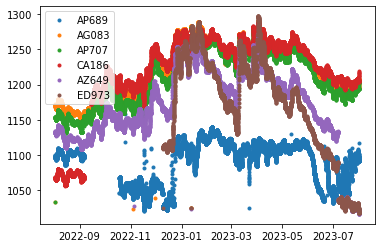

In [5]:
# initial test to see if imported data are ok in time
names=['AP689','AG083','AP707','CA186','AZ649','ED973']
for i in names:
    plt.plot(GWdata.loc[GWdata["SerialNumber"]==i].Date,
        GWdata.loc[GWdata["SerialNumber"]==i].Pressure,'.', label=i)
plt.legend()

In [ ]:
# i='AG083'
# GWdata.loc[GWdata["SerialNumber"]==i].sort_values(by=['Date'])
# ddd=GWdata.loc[GWdata["SerialNumber"]==i].reset_index()
# #print(ddd)
# dataall=baro_data.merge(ddd[['TimeStamp','Pressure']], on='TimeStamp')
# dataall = dataall.drop_duplicates()
# #dataall.SerialNumber='AG083'
# #dataall[dataall['Pressure_y'].notna()]
# #dataall = dataall[dataall['Pressure_x']<dataall['Pressure_y']]
# #dataall["WL"]=(dataall['Pressure_y']-dataall['Pressure_x'])
# #dataall=dataall.reset_index()
# # dataall
# # GWdata.loc[GWdata["SerialNumber"]=='AG083'].sort_values(by=['Date']).reset_index()
# # baro_data

In [6]:
# Read manually measured water dephts for inspection of the data    
# path_obs=os.path.join(path1, 'data','raw_data')
file_obs = os.path.join(path_obs, 'manual_check_water_depth.xlsx')
df_info = pd.read_excel(file_obs)
df_info['Time']=pd.to_datetime(df_info['Time'],dayfirst=True)
(df_info.Time)
df_info2=df_info[df_info.Time.notnull()]
df_info2=df_info2.reset_index(drop=True)
df_info2.iloc[:,3] = (-100*df_info2.iloc[:,3]) 
df_info2.iloc[:,4] =-100*df_info2.iloc[:,4] 
groups = df_info2.groupby('SerialNumber')
colors = {'AG083':'#ff7f0e','AP707': '#8c564b','CA186': '#d62728','AZ649': '#2ca02c', 'CA969':'#9467bd', 'ED973':'#9467bd'}


## Processing steps

Dataset Processing explanation						
1. Collect total pressure (TP) from divers		 (cmH2O)				
2. Calculate water pressure (WP) = TP - AP		 (cmH2O)		
3. Calculate hydraulic gradient. Take the timestep "t" at which a manual measurement is realized and calculate the hydraulic head						
     - H(t) = TW-WD(t)						
     - H (t+1) = H(t)  + (WP (t+1) - WP (t))/100						
																	
With :											
AP= Air Pressure (cmH20)											
H=Hydraulic Head (mTAW)						
TW=Top well Elevation (mTAW)						
WD=Water depth from the top well (m)												
						
| well   name | well   name | soil elevation(mTAW) | well height above the ground (m) | Top well (mTAW) | rope length (m)|
|:-----------:|:-----------:|:--------------------:|:--------------------------------:|:---------------:|:------------|
|  AG083  |   a   |         21,30        |                 0.56                |      21,86      |    |
|   AP707   |   b   |        20,5        |               0.43               |      20.93      |      |
|   CA186  |   c   |       19,7         |               0.63               |        20.33    |        |
|   AZ649   |   d   |         20,9        |              0.68                |      21.58      |      |
|   CA969/ED973  |  e  |         22,3        |                0.7               |      23.0     |       |
|   AP689   |     |                 |                            |            |           |

***---------------------------------------------------------------------------------------------------***
#### To Do:  the new CT divers should be replaced too

In [ ]:
# path1 = os.getcwd()
# path = os.path.join(path1, 'data')
# file = os.path.join(path, 'PiezoD22mar_adapted.csv')
# PiezoD=pd.read_csv(file,sep=';',dayfirst=True)

# print(PiezoD)
# print(PiezoD['GWL'])

In [ ]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


      index MonitoringPoint SerialNumber           TimeStamp  Pressure_x  \
0         1            ILVO        AG083 2022-08-02 17:00:00    1035.825   
1         3            ILVO        AG083 2022-08-02 18:00:00    1035.075   
2         4            ILVO        AG083 2022-08-02 19:00:00    1035.075   
3         5            ILVO        AG083 2022-08-02 20:00:00    1035.200   
4         6            ILVO        AG083 2022-08-02 21:00:00    1035.425   
...     ...             ...          ...                 ...         ...   
5519   5524            ILVO        AG083 2023-03-22 09:00:00    1028.375   
5520   5525            ILVO        AG083 2023-03-22 10:00:00    1028.050   
5521   5526            ILVO        AG083 2023-03-22 11:00:00    1027.875   
5522   5527            ILVO        AG083 2023-03-22 12:00:00    1027.425   
5523   5528            ILVO        AG083 2023-03-22 13:00:00    1027.550   

      Temperature  Conductivity  WaterLevel  WaterLevelReference  \
0       33.663333  

KeyError: 'AZ648'

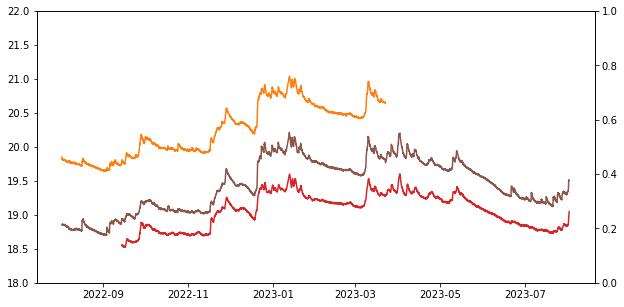

In [8]:
wellinfo = { 'SerialNumber' : ['AG083','AP707','CA186','AZ649','CA969','ED973'], 
            'WellName' : {'a','b','c','d','e','e1'},
            'lgnds' : ['a','b','c','d','e'],
            'soil_mTAW' : [21.42,20.57,19.86,21.20,22.15,22.15],
            'well_height' : [0.56,0.43,0.63,0.68,0.70,0.28],
            'top_well_cm' :[2198,2100,2049,2188,2285,2243],
            'RL' : [350,332,341,370,377,345],
            'L1':[294,289,278,302,307,317],
            'initials' : [158,165,147,225,0,0],
            'measure_time':['2022-08-02 17:30:00','2022-08-02 17:00:00',
                        '2022-08-02 15:00:00','2022-08-02 11:00:00',
                        '2022-08-02 13:00:00','2023-12-09 10:00:00'],
           'long':[108855,108899,108929,108884,108814,108814],
           'lat':[185311,185293,185281,185274,185203,185203]}
alldata={}
dov={}
date1=datetime.date(2022,8,1)
date2=datetime.date(2023,8,1)
ftsz=16

fig, ax= plt.subplots(figsize=(10,5))
axb=ax.twinx()



for f,i in enumerate(wellinfo['SerialNumber']):
    ddd=GWdata.loc[GWdata["SerialNumber"]==i].reset_index()
    dataall=baro_data.merge(ddd[['TimeStamp','Pressure']], on='TimeStamp')
    dataall.SerialNumber=i
    dataall[dataall['Pressure_y'].notna()]
    dataall = dataall[dataall['Pressure_x']<dataall['Pressure_y']]
    dataall["WL"]=(dataall['Pressure_y']-dataall['Pressure_x'])
    dataall=dataall.reset_index()
    if wellinfo['SerialNumber'][f]=='AZ649':
        # calculate GWL manually in Excel
        dataall["GWL"]=PiezoD["GWL"]
        dataall.to_excel('saved_file.xlsx')
    else:
        dataall["GWL"]=-wellinfo['RL'][f]+wellinfo['top_well_cm'][f]+dataall["WL"]
    if wellinfo['SerialNumber'][f]=='AG083':
        dataA = dataall
        dataall.to_excel('saved_file_headA.xlsx')
        print(dataA)
    if wellinfo['SerialNumber'][f]=='AP707':
        dataB = dataall
        dataall.to_excel('saved_file_headB.xlsx')
    if wellinfo['SerialNumber'][f]=='CA186':
        dataC = dataall
        dataall.to_excel('saved_file_headC.xlsx')
    if wellinfo['SerialNumber'][f]=='AZ649':
        dataD = dataall
        dataall.to_excel('saved_file_headD.xlsx')
        print(dataD)
    if wellinfo['SerialNumber'][f]=='CA969':
        dataE1 = dataall
        dataall.to_excel('saved_file_headE1.xlsx')
    if wellinfo['SerialNumber'][f]=='ED973':
        dataE2 = dataall
        dataall.to_excel('saved_file_headE2.xlsx')
    if wellinfo['SerialNumber'][f]=='CA186':
        ax.plot(dataall.TimeStamp[840:],(dataall["GWL"][840:]/100),colors[i])
    else:
        ax.plot(dataall.TimeStamp,(dataall["GWL"]/100),colors[i])
    ax.set_ylim([18,22])
    alldata[i]=dataall

ax.scatter(df_info2.Time, df_info2.iloc[:,5], 75,c=df_info2['SerialNumber'].map(colors),alpha=.2, marker='o')
ax.vlines(x='2022-12-22', ymin=18, ymax=22)
ax.legend(wellinfo['lgnds'],loc='upper left', fontsize=ftsz)
ax.set_ylabel('GWL[mTAW]', fontsize= ftsz)
ax.tick_params(axis='x', which='both', labelsize=ftsz-2,rotation=60)
ax.tick_params(axis='y', which='both', labelsize=ftsz)
#ax.hlines(y=21.3, xmin = date1, xmax = date2, color='#ff7f0e', linestyle = '--')
#ax.hlines(y=20.5, xmin = date1, xmax = date2,color='#8c564b', linestyle = '--')
#ax.hlines(y=19.7, xmin = date1, xmax = date2,color='#d62728', linestyle = '--')
#ax.hlines(y=20.9, xmin = date1, xmax = date2,color='#2ca02c', linestyle = '--')
#ax.hlines(y=22.3, xmin = date1, xmax = date2,color='#9467bd', linestyle = '--')


axb.bar(climday['date'],climday.precipitation_sum)
axb.set_ylim([0, 30])
axb.invert_yaxis()
axb.set_ylabel('Precipitation [mm]', fontsize= ftsz)
axb.tick_params(axis='x', which='both', labelsize=ftsz)
axb.tick_params(axis='y', which='both', labelsize=ftsz)

axb.set_xlim([date1,date2])
fig.show()


In [ ]:
frames = [dataE1, dataE2]
dataE = pd.concat(frames)
dataE.to_excel('saved_file_headE.xlsx')

In [ ]:
fig.savefig('GWL.png')

In [ ]:
## Below surface depth

In [ ]:
wellinfo = { 'SerialNumber' : ['AG083','AP707','CA186','AZ649','CA969','ED973'], 
            'WellName' : {'a','b','c','d','e','e1'},
            'lgnds' : ['a','b','c','d','e'],
            'soil_mTAW' : [21.42,20.57,19.86,21.20,22.15,22.15],
            'well_height_m' : [0.56,0.43,0.63,0.68,0.70,0.28],
            'top_well_cm' :[2198,2100,2049,2188,2285,2243],
            'RL' : [350,332,341,370,377,345],
            'L1':[294,289,278,302,307,317],
            'initials' : [158,165,147,225,0,0],
            'measure_time':['2022-08-02 17:30:00','2022-08-02 17:00:00',
                        '2022-08-02 15:00:00','2022-08-02 11:00:00',
                        '2022-08-02 13:00:00','2023-12-09 10:00:00'],
           'long':[108855,108899,108929,108884,108814,108814],
           'lat':[185311,185293,185281,185274,185203,185203]}
alldata1={}
date1=datetime.date(2022,8,1)
date2=datetime.date(2023,3,23)
ftsz=16

fig, ax= plt.subplots(figsize=(10,5))
axb=ax.twinx()

for f,i in enumerate(wellinfo['SerialNumber']):
    ddd1=GWdata.loc[GWdata["SerialNumber"]==i].reset_index()
    dataall1=baro_data.merge(ddd1[['TimeStamp','Pressure']], on='TimeStamp')
    dataall1.SerialNumber=i
    dataall1[dataall1['Pressure_y'].notna()]
    dataall1 = dataall1[dataall1['Pressure_x']<dataall1['Pressure_y']]
    dataall1["WL"]=(dataall1['Pressure_y']-dataall1['Pressure_x'])
    dataall1=dataall1.reset_index()
    if wellinfo['SerialNumber'][f]=='AZ649':
        dataall1["GWL"]=PiezoD["BSS"]
    else:
        dataall1["GWL"]=wellinfo['RL'][f]-wellinfo['well_height_m'][f]-dataall1["WL"]
    if wellinfo['SerialNumber'][f]=='CA186':
        ax.plot(dataall1.TimeStamp[840:],-( dataall1["GWL"][840:]/100),colors[i])
    else:
        ax.plot(dataall1.TimeStamp,-( dataall1["GWL"]/100),colors[i])
    ax.set_ylim([-4,0])
    alldata1[i]=dataall1
    

#ax.scatter(df_info2.Time, df_info2.iloc[:,4]/100, 75,c=df_info2['SerialNumber'].map(colors),alpha=.2, marker='o')
ax.legend(wellinfo['lgnds'],loc='upper left', fontsize=ftsz)
ax.set_ylabel('GWL[b.s.s, m]', fontsize= ftsz)
ax.tick_params(axis='x', which='both', labelsize=ftsz-2,rotation=60)
ax.tick_params(axis='y', which='both', labelsize=ftsz)



axb.bar(climday['date'],climday.precipitation_sum)
axb.set_ylim([0, 30])
axb.invert_yaxis()
axb.set_ylabel('Precipitation [mm]', fontsize= ftsz)
axb.tick_params(axis='x', which='both', labelsize=ftsz)
axb.tick_params(axis='y', which='both', labelsize=ftsz)

axb.set_xlim([date1,date2])
fig.savefig('GWL_bss.png')


# calculate Gradients [H2-H1/(Distance)], 
# H mtaw between each pair of piezometer like (a,b), (b,c), (c,d),(b,d),(a,d)
| distance matrix | a | b | c | d | e |
|:-----------:|:-----------:|:--------------------:|:--------------------------------:|:---------------:|:------------|
|  a  |   -  |         47,621        |                 79,562                |      46,382      |  115,062  |
|   b   |   47,621   |         -       |              32,528               |      24,529      |  123,775    |
|   c  |   79,562   |       32,528         |            -                  |        45,460    |     138,869   |
|   d   |   46,382   |         24,529        |              45,460                |      -      |   99,504   |
|   e  |  115,062  |         123,775        |                138,869               |      99,504     |   -    |

In [ ]:
### (a,b) ###
dataA1 = dataA.drop_duplicates(subset=['Date'])
dataB1 = dataB.drop_duplicates(subset=['Date'])
dataA1 = dataA1[['Date','GWL']]
dataB1 = dataB1[["Date", 'GWL']]
#dataB2 = dataB1.drop(dataB1.loc[dataB1['Date'] == '2022-11-04 11:00:00'].index)
dataA1 = dataA1.set_index('Date')
dataB1 = dataB1.set_index('Date')
diffAB = (dataA1['GWL'] - dataB1['GWL'])
hydgraAB = diffAB/4762.1 
hydgraAB = hydgraAB.reset_index()
### (a,c) ###
dataC1 = dataC.drop_duplicates(subset=['Date'])
dataC2 = dataC1[['Date','GWL']]
#dataC2 = dataC2.drop(dataC2.loc[dataC['Date'] == '2022-08-02 15:00:00'].index)
#dataC2 = dataC2.drop(dataC2.loc[dataC['Date'] == '2022-08-02 16:00:00'].index)
#dataA1 = dataA1.reset_index()
#dataA2 = dataA1[(dataA1.Date < '2022-09-06 14:00:00') | (dataA1.Date > '2022-09-14 13:00:00')]
#dataA2 = dataA1.set_index('Date')
dataC2 = dataC2.set_index('Date')
diffAC = (dataA1['GWL'] - dataC2['GWL'])
hydgraAC = diffAC/7956.2 
hydgraAC = hydgraAC.reset_index()
### (a,d) ###
dataD1 = dataD.drop_duplicates(subset=['Date'])
dataD2 = dataD1[['Date','GWL']]
dataD2 = dataD2.set_index('Date')
#dataA2 = dataA1.set_index('Date')
diffAD = (dataA1['GWL'] - dataD2['GWL'])
hydgraAD = diffAD/4638.2 
hydgraAD = hydgraAD.reset_index()
### (b,c) ###
diffBC = (dataB1['GWL'] - dataC2['GWL'])
hydgraBC = diffBC/3252.8
hydgraBC = hydgraBC.reset_index()
### (b,d) ###
diffBD = (dataB1['GWL'] - dataD2['GWL'])
hydgraBD = diffBD/3252.8
hydgraBD = hydgraBD.reset_index()
### (c,d) ###
diffCD = (dataC2['GWL'] - dataD2['GWL'])
hydgraCD = diffCD/3252.8
hydgraCD = hydgraCD.reset_index()
### (a,e) ###
dataE_1 = dataE.drop_duplicates(subset=['Date'])
dataE_1 = dataE_1[['Date','GWL']]
dataE_1 = dataE_1.set_index('Date')
diffAE = (dataA1['GWL'] - dataE_1['GWL'])
hydgraAE = diffAE/11506.2
hydgraAE = hydgraAE.reset_index()
### (b,e) ###
diffBE = (dataB1['GWL'] - dataE_1['GWL'])
hydgraBE = diffBE/12377.5
hydgraBE = hydgraBE.reset_index()
### (c,e) ###
diffCE = (dataC2['GWL'] - dataE_1['GWL'])
hydgraCE = diffCE/13886.9
hydgraCE = hydgraCE.reset_index()
### (d,e) ###
diffDE = (dataD2['GWL'] - dataE_1['GWL'])
hydgraDE = diffDE/9950.4
hydgraDE = hydgraDE.reset_index()

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(hydgraAB['Date'], hydgraAB['GWL'], label='AB')
plt.plot(hydgraAC.Date[840:], hydgraAC.GWL[840:], label='AC')
plt.plot(hydgraAD.Date, hydgraAD.GWL, label='AD')
plt.plot(hydgraAE['Date'], hydgraAE['GWL'], label='AE')
plt.plot(hydgraBC.Date[840:], hydgraBC.GWL[840:], label='BC')
plt.plot(hydgraBD.Date, hydgraBD.GWL, label='BD')
plt.plot(hydgraBE['Date'], hydgraBE['GWL'], label='BE')
plt.plot(hydgraCD.Date[840:], hydgraCD.GWL[840:], label='CD')
plt.plot(hydgraCE.Date[840:], hydgraCE.GWL[840:], label='CE')
plt.plot(hydgraDE['Date'], hydgraDE['GWL'], label='DE')
plt.axhline(y = 0, color = 'k', linestyle = '--')
plt.legend(fontsize = 10, bbox_to_anchor = (1.11, 0.5), loc='center right')
plt.ylabel('Hydraulic gradient', fontsize = 12)
plt.xlabel('Time', fontsize = 10)
plt.xticks(rotation = 45) 
plt.show
plt.savefig('HydraulicGradients.png')

## TIME SERIES ANALYSIS ##

In [ ]:
# Import packages
import pandas as pd
import pastas as ps
# Read time series
path1 = os.getcwd()
path = os.path.join(path1, 'data', 'TimeSeries')
file_obs = os.path.join(path, 'GWL_A.csv')
obs = pd.read_csv(file_obs, sep=';', parse_dates=True).squeeze()
obs['Date'] = pd.to_datetime(obs['Date'], format = '%d/%m/%Y')
obs_daily = obs.resample('D', on='Date').mean()
#obs_daily = obs_daily.squeeze()
print("The data type of the oseries is: %s" % type(obs_daily))
file_rain = os.path.join(path, 'Precipitation.csv')
rain = pd.read_csv(file_rain, sep=';', parse_dates=True).squeeze()
rain['Date'] = pd.to_datetime(rain['Date'], format = '%d/%m/%Y')
rain_daily = rain.resample('D', on='Date').sum()
#rain_daily = rain_daily.squeeze()
print(obs_daily)
print(rain_daily)
obs_daily.plot(style=".", figsize=(10, 4))
rain_daily.plot.bar(figsize=(10, 4))

In [ ]:
# Create model
ml = ps.Model(obs_daily, name='PiezometerA')
# Add stress models
rm = ps.StressModel(rain_daily,rfunc=ps.Gamma, name='recharge', settings="evap")
ml.add_stressmodel(rm)
# Solve the model
ml.solve()
ml.plot()
ml.plots.results(figsize=(10, 6))
